In [2]:
import numpy as np
from utils_clean import generate_sample, DEOptim, RandomOptim, PSOOptim, visualize_meshgrid, get_likelihood_grids, visualize_pred_meshgrid
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

## Generate Data

In [3]:

target_func = lambda X: (20 + X**2 - 10 * np.cos(2*np.pi*X)).sum(axis=0)

n_dims = 2
lower_bound = -2.5, -1.5
upper_bound = +1.5, +2.5

X, y = generate_sample(70, n_dims, lower_bound, upper_bound, target_func)

In [4]:
# rs = PSOOptim(c1=0.1, c2=0.3, w=0.9, n_iters=100, visualize=True, n_particles=10)
# gpr_rs = GaussianProcessRegressor(optimizer=rs.optimize, kernel=RBF(length_scale=(1, 1)))
# gpr_rs.fit(X.T, y[...,None])
# y_pred = gpr_rs.predict(X.T)

# x_grid, y_grid, z_grid = get_likelihood_grids(gpr_rs)
# rs.visualize_optimization(x_grid, y_grid, z_grid, "Videos/PSO_vogel.mp4")

In [5]:
# from IPython.display import Video

# Video("PSO.mp4")

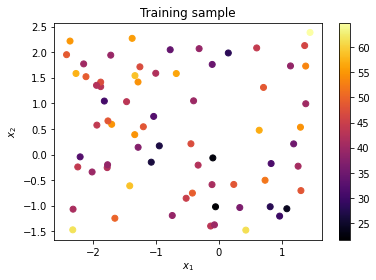

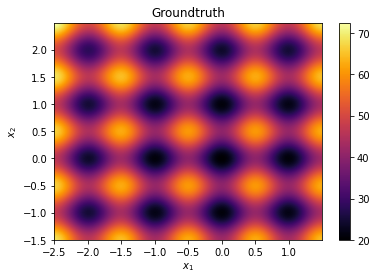

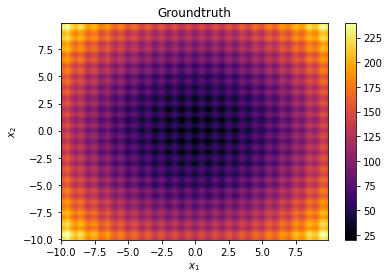

In [6]:
plt.scatter(X[0], X[1], c=y, cmap="inferno")
plt.title("Training sample")
plt.ylabel("$x_2$")
plt.xlabel("$x_1$")
plt.colorbar()
plt.show()

# plt.figure(dpi=600)
plt.ylabel("$x_2$")
plt.xlabel("$x_1$")
m = np.arange(-2.5,1.5,0.001)
p = np.arange(-1.5,2.5,0.001)
visualize_meshgrid(m, p, target_func, title='Groundtruth')
plt.show()

# plt.figure(dpi=600)
plt.ylabel("$x_2$")
plt.xlabel("$x_1$")
m = np.arange(-10,10,0.1)
p = np.arange(-10,10,0.1)
visualize_meshgrid(m, p, target_func, title='Groundtruth')
plt.show()

## GPR with Differential Evolution

In [7]:
optim = DEOptim()
gpr_de = GaussianProcessRegressor(optimizer=optim.optimize, kernel=RBF(length_scale=(1,1)))
gpr_de.fit(X.T, y[...,None])
y_pred = gpr_de.predict(X.T)

In [8]:
print(f'''Training Errors:
          Log Marginal Likelihood: {gpr_de.log_marginal_likelihood_value_}
          Mean Squared Error: {mean_squared_error(y, y_pred)}
          R2 Score: {r2_score(y, y_pred)}
          MAPE: {mean_absolute_percentage_error(y, y_pred)}
''')

Training Errors:
          Log Marginal Likelihood: -34146.927640704205
          Mean Squared Error: 9.980415891861959e-17
          R2 Score: 1.0
          MAPE: 1.5868676385117554e-10



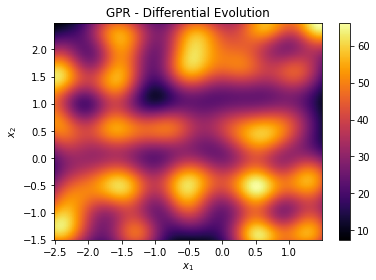

In [9]:
visualize_pred_meshgrid(gpr_de, "GPR - Differential Evolution")

In [10]:
n = 100
x_grid = np.linspace(-5, -0.75, n)
y_grid = np.linspace(-5, -0.75, n)
X_grid = np.array(np.meshgrid(x_grid, y_grid))
X_grid  = X_grid.swapaxes(0, 2)
X_grid = X_grid.reshape((-1, 2))
z = np.asarray([gpr_de.log_marginal_likelihood(X) for X in X_grid])
z = z.reshape(n, n)

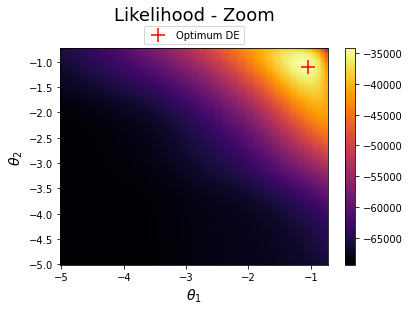

In [11]:
plt.pcolormesh(x_grid, y_grid, z, cmap="inferno")
plt.colorbar()
plt.scatter(gpr_de.kernel_.theta[0], gpr_de.kernel_.theta[1], marker="+", color="red", s=200, label="Optimum DE")
plt.xlabel(r"$\theta_1$", fontsize=14)
plt.ylabel(r"$\theta_2$", fontsize=14)
plt.title("Likelihood - Zoom", y=1.1, fontsize=18)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.125, 0, 0))

## GPR with Random Search

In [12]:
rs = RandomOptim(maxiter=100, visualize=True)
gpr_rs = GaussianProcessRegressor(optimizer=rs.optimize, kernel=RBF(length_scale=(1,1)))
gpr_rs.fit(X.T, y[...,None])
y_pred = gpr_rs.predict(X.T)
# from utils_clean import get_likelihood_grids
# x, y, z = get_likelihood_grids(gpr_rs)
# rs.visualize_optimization(x, y, z, "Random Search.mp4")

In [13]:
print(f'''Training Errors:
          Log Marginal Likelihood: {gpr_rs.log_marginal_likelihood_value_}
          Mean Squared Error: {mean_squared_error(y, y_pred)}
          R2 Score: {r2_score(y, y_pred)}
          MAPE: {mean_absolute_percentage_error(y, y_pred)}
''')

Training Errors:
          Log Marginal Likelihood: -60232.37943734049
          Mean Squared Error: 1.9686274913765865e-16
          R2 Score: 1.0
          MAPE: 1.396860755724285e-10



## GPR with PSO

In [14]:
seed = np.random.RandomState(42)
part = 10
dim = 2
pso = PSOOptim(n_iters=10, n_particles=part, c1=0.5, c2=0.3, w=0.9, init_pos=(seed.rand(part, dim)*22)-11, visualize=True)
gpr_pso = GaussianProcessRegressor(optimizer=pso.optimize, kernel=RBF(length_scale=(1,1)))
gpr_pso.fit(X.T, y[...,None])
y_pred = gpr_pso.predict(X.T)

2022-08-06 22:31:39,336 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=3.54e+4
2022-08-06 22:31:39,453 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35410.76633274153, best pos: [-0.94718876 -1.32651943]


In [15]:
print(f'''Training Errors:
          Log Marginal Likelihood: {gpr_pso.log_marginal_likelihood_value_}
          Mean Squared Error: {mean_squared_error(y, y_pred)}
          R2 Score: {r2_score(y, y_pred)}
          MAPE: {mean_absolute_percentage_error(y, y_pred)}
''')

Training Errors:
          Log Marginal Likelihood: -35410.76633274153
          Mean Squared Error: 6.790288050282566e-17
          R2 Score: 1.0
          MAPE: 1.3240477434935128e-10



In [16]:
gpr_pso.kernel_.theta

array([-0.94718876, -1.32651943])

In [17]:
n = 100
x_grid = np.linspace(-10, 10, n)
y_grid = np.linspace(-10, 10, n)
X_grid = np.array(np.meshgrid(x_grid, y_grid))
X_grid  = X_grid.swapaxes(0, 2)
X_grid = X_grid.reshape((-1, 2))
z = np.asarray([gpr_de.log_marginal_likelihood(X) for X in X_grid])
z = z.reshape(n, n)

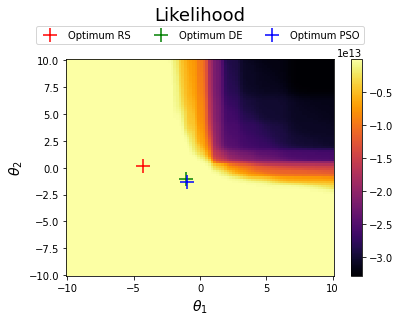

In [18]:
plt.pcolormesh(x_grid, y_grid, z, cmap="inferno")
plt.colorbar()
plt.scatter(gpr_rs.kernel_.theta[0], gpr_rs.kernel_.theta[1], marker="+", color="red", s=200, label="Optimum RS")
plt.scatter(gpr_de.kernel_.theta[0], gpr_de.kernel_.theta[1], marker="+", color="green", s=200, label="Optimum DE")
plt.scatter(gpr_pso.kernel_.theta[0], gpr_pso.kernel_.theta[1], marker="+", color="blue", s=200, label="Optimum PSO")
plt.xlabel(r"$\theta_1$", fontsize=14)
plt.ylabel(r"$\theta_2$", fontsize=14)
plt.title("Likelihood", y=1.15, fontsize=18)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.175, 0, 0), ncol=3)

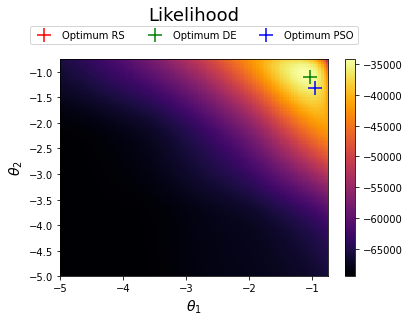

In [19]:
n = 100
x_grid = np.linspace(-5, -0.75, n)
y_grid = np.linspace(-5, -0.75, n)
X_grid = np.array(np.meshgrid(x_grid, y_grid))
X_grid  = X_grid.swapaxes(0, 2)
X_grid = X_grid.reshape((-1, 2))
z = np.asarray([gpr_de.log_marginal_likelihood(X) for X in X_grid])
z = z.reshape(n, n)

plt.pcolormesh(x_grid, y_grid, z, cmap="inferno")
plt.colorbar()
plt.scatter(gpr_rs.kernel_.theta[0], gpr_rs.kernel_.theta[1], marker="+", color="red", s=200, label="Optimum RS")
plt.scatter(gpr_de.kernel_.theta[0], gpr_de.kernel_.theta[1], marker="+", color="green", s=200, label="Optimum DE")
plt.scatter(gpr_pso.kernel_.theta[0], gpr_pso.kernel_.theta[1], marker="+", color="blue", s=200, label="Optimum PSO")
plt.xlabel(r"$\theta_1$", fontsize=14)
plt.ylabel(r"$\theta_2$", fontsize=14)
plt.xlim(-5, -0.75)
plt.ylim(-5, -0.75)
plt.title("Likelihood", y=1.15, fontsize=18)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.175, 0, 0), ncol=3)

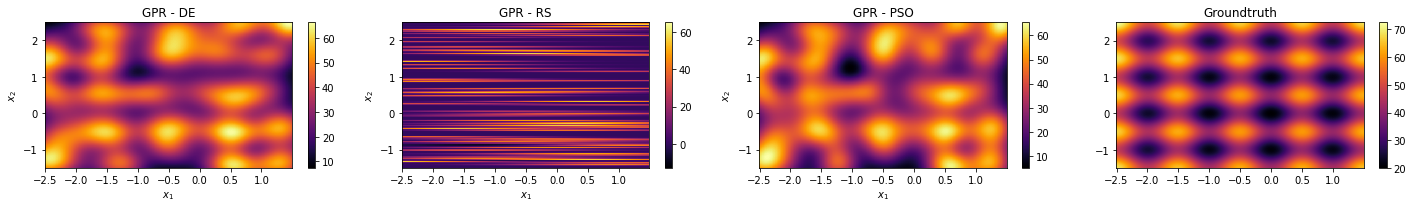

In [20]:
plt.figure(figsize=(20,3))
plt.subplot(141)
visualize_pred_meshgrid(gpr_de, "GPR - DE")
plt.subplot(142)
visualize_pred_meshgrid(gpr_rs, "GPR - RS")
plt.subplot(143)
visualize_pred_meshgrid(gpr_pso, "GPR - PSO")
plt.subplot(144)
m = np.arange(-2.5,1.5,0.001)
p = np.arange(-1.5,2.5,0.001)
visualize_meshgrid(m, p, target_func, title='Groundtruth')
plt.tight_layout()
plt.show()

100%|██████████| 10000/10000 [00:06<00:00, 1516.44it/s]
2022-08-06 22:32:09,980 - matplotlib.animation - WARNING - MovieWriter ffmpeg unavailable; using Pillow instead.
2022-08-06 22:32:09,981 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


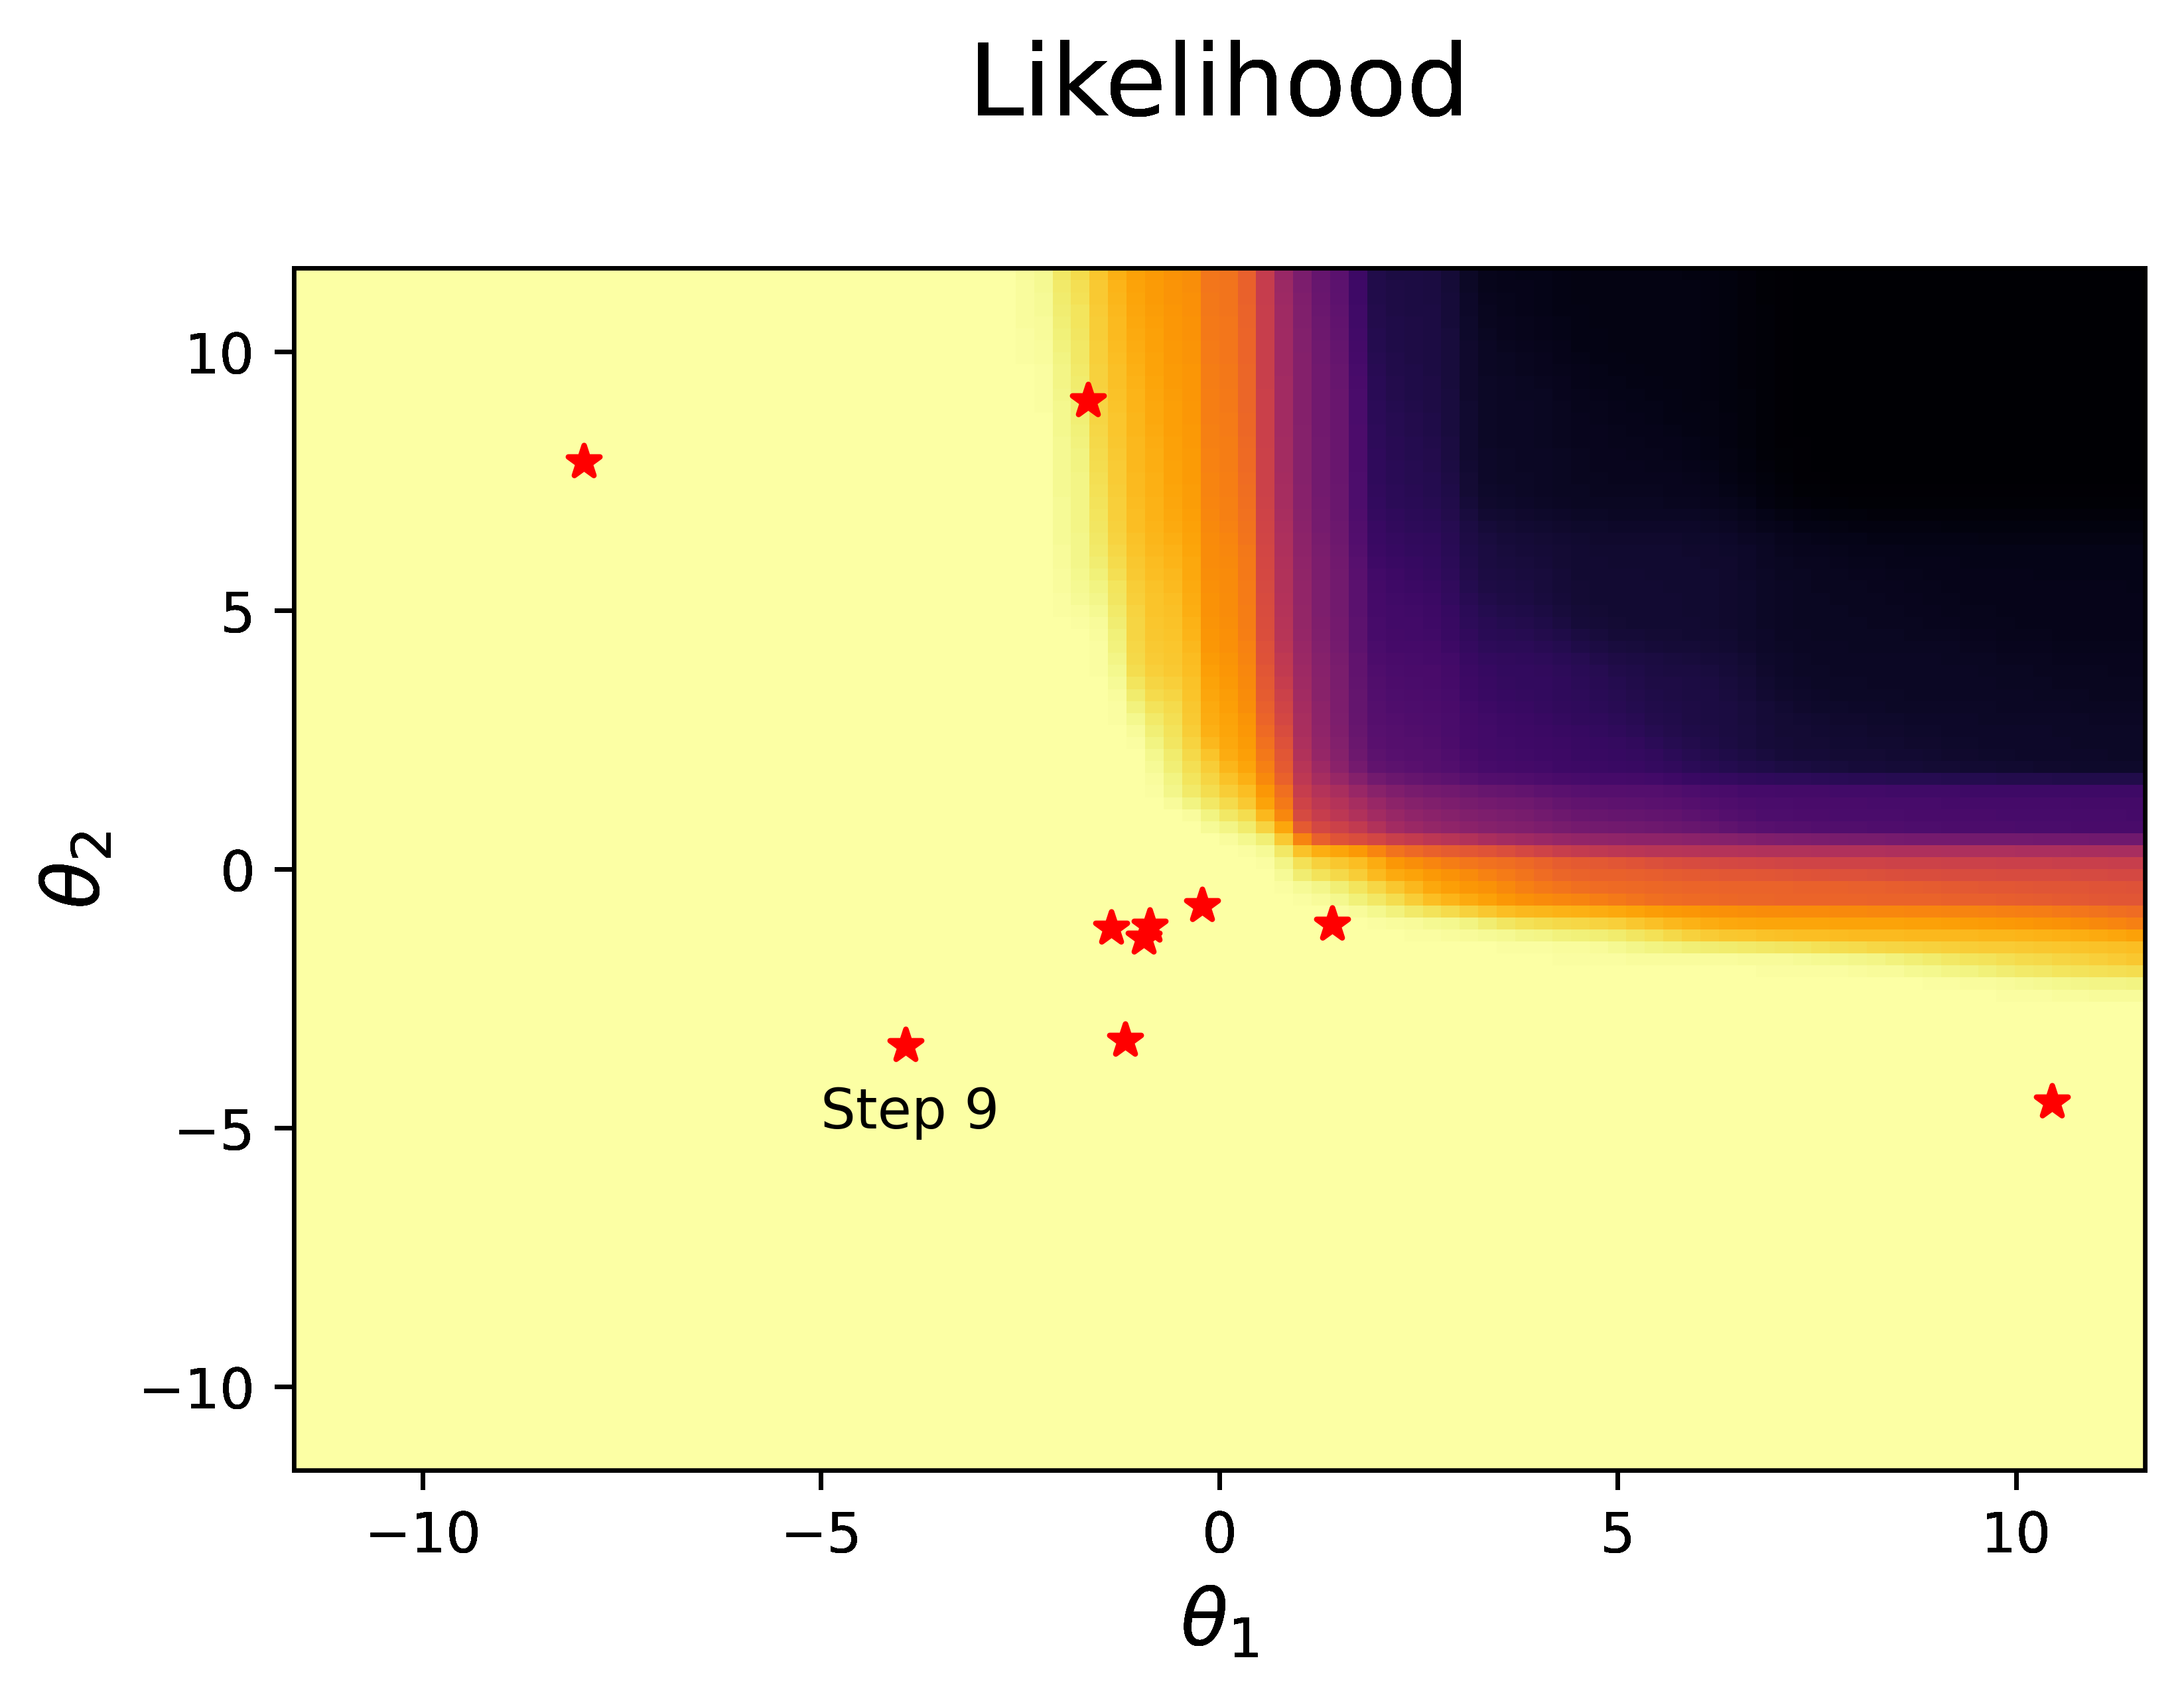

In [21]:
from utils_clean import get_likelihood_grids
x_grid, y_grid, z_grid = get_likelihood_grids(gpr_pso)
pso.visualize_optimization(x_grid, y_grid, z_grid, "Videos/PSO.gif", show_zaeff=False)

In [23]:
import pandas as pd
df_iter_res = pd.DataFrame({"Iteration":[], "DE_t1":[], "PSO_t1":[], "RS_t1":[], "DE_t2":[], "PSO_t2":[], "RS_t2":[]})

for i in range(20):
    de = DEOptim()
    gpr_de = GaussianProcessRegressor(optimizer=de.optimize, kernel=RBF(length_scale=(1,1)))
    gpr_de.fit(X.T, y[...,None])

    pso = PSOOptim()
    gpr_pso = GaussianProcessRegressor(optimizer=pso.optimize, kernel=RBF(length_scale=(1,1)))
    gpr_pso.fit(X.T, y[...,None])

    rs = RandomOptim(random_state=i, maxiter=100)
    gpr_rs = GaussianProcessRegressor(optimizer=rs.optimize, kernel=RBF(length_scale=(1,1)))
    gpr_rs.fit(X.T, y[...,None])

    df_iter_res.loc[len(df_iter_res)] = [i, gpr_de.kernel_.theta[0], gpr_pso.kernel_.theta[0], gpr_rs.kernel_.theta[0], gpr_de.kernel_.theta[1], gpr_pso.kernel_.theta[1], gpr_rs.kernel_.theta[1]]
df_iter_res

2022-08-06 22:32:39,933 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=3.73e+4
2022-08-06 22:32:40,080 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 37265.93190824838, best pos: [-1.46488964 -0.93712753]
2022-08-06 22:32:40,417 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=3.56e+4
2022-08-06 22:32:40,558 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35599.59722776931, best pos: [-1.29715775 -0.99868571]
2022-08-06 22:32:40,928 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=5.97e+4
2022-08-06 22:32:41,055 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 59748.35712184662

,Iteration,DE_t1,PSO_t1,RS_t1,DE_t2,PSO_t2,RS_t2
0,0.0,-1.039197,-1.464890,3.688132,-1.096919,-0.937128,-4.833642
1,1.0,-1.039197,-1.297158,-3.991649,-1.096919,-0.998686,0.623036
2,2.0,-1.039197,2.796479,-1.718482,-1.096919,-5.012442,-1.276225
3,3.0,-1.039197,-0.898592,-2.152458,-1.096919,-1.243023,-0.715177
4,4.0,-1.039197,-0.278528,-2.864974,-1.096919,-2.987013,0.058326
5,5.0,-1.039197,-1.217842,-0.936102,-1.096919,-1.721637,-1.873059
6,6.0,-1.039197,-0.960716,-1.139796,-1.096919,-1.950479,-2.905668
7,7.0,-1.039197,-0.856449,-2.938451,-1.096919,-1.396932,-0.520358
8,8.0,1.087785,-1.308880,-1.500912,-4.261140,-1.853516,-1.577417
9,9.0,-1.039197,9.256330,-0.507167,-1.096919,-5.035602,-1.483890


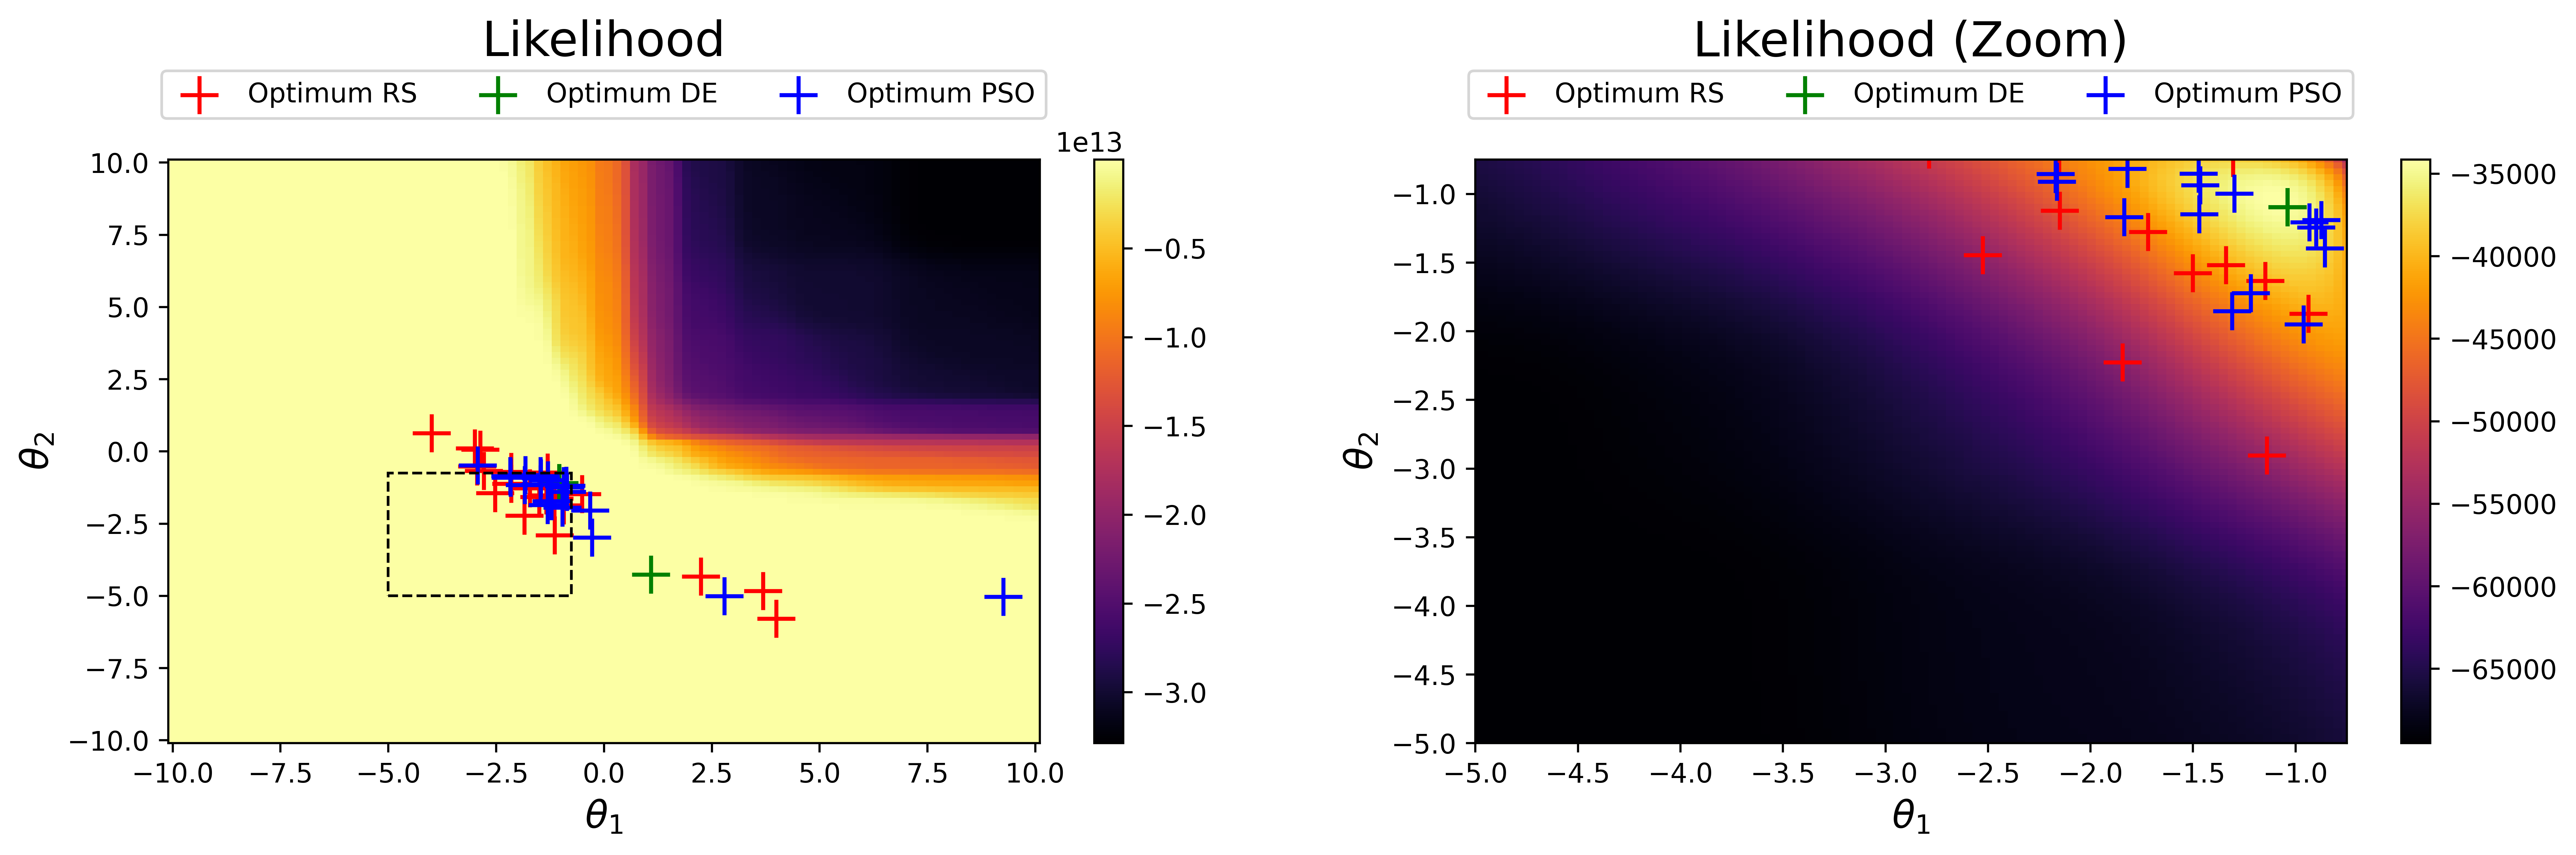

In [30]:
import matplotlib.patches as pt

plt.figure(figsize=(16,4), dpi=600)
plt.subplot(121)
n = 100
x_grid = np.linspace(-10, 10, n)
y_grid = np.linspace(-10, 10, n)
X_grid = np.array(np.meshgrid(x_grid, y_grid))
X_grid  = X_grid.swapaxes(0, 2)
X_grid = X_grid.reshape((-1, 2))
z = np.asarray([gpr_de.log_marginal_likelihood(X) for X in X_grid])
z = z.reshape(n, n)

plt.pcolormesh(x_grid, y_grid, z, cmap="inferno")
plt.colorbar()
plt.scatter(df_iter_res["RS_t1"], df_iter_res["RS_t2"], marker="+", color="red", s=200, label="Optimum RS")
plt.scatter(df_iter_res["DE_t1"], df_iter_res["DE_t2"], marker="+", color="green", s=200, label="Optimum DE")
plt.scatter(df_iter_res["PSO_t1"], df_iter_res["PSO_t2"], marker="+", color="blue", s=200, label="Optimum PSO")
plt.xlabel(r"$\theta_1$", fontsize=14)
plt.ylabel(r"$\theta_2$", fontsize=14)
plt.title("Likelihood", y=1.15, fontsize=18)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.175, 0, 0), ncol=3)
rect = pt.Rectangle(xy=(-5,-5), height=4.25, width=4.25, linewidth=1, edgecolor='black', facecolor='none', linestyle="--")
plt.gca().add_patch(rect)

n = 100
x_grid = np.linspace(-5, -0.75, n)
y_grid = np.linspace(-5, -0.75, n)
X_grid = np.array(np.meshgrid(x_grid, y_grid))
X_grid  = X_grid.swapaxes(0, 2)
X_grid = X_grid.reshape((-1, 2))
z = np.asarray([gpr_de.log_marginal_likelihood(X) for X in X_grid])
z = z.reshape(n, n)

plt.subplot(122)

plt.pcolormesh(x_grid, y_grid, z, cmap="inferno")
plt.colorbar()
plt.scatter(df_iter_res["RS_t1"], df_iter_res["RS_t2"], marker="+", color="red", s=200, label="Optimum RS")
plt.scatter(df_iter_res["DE_t1"], df_iter_res["DE_t2"], marker="+", color="green", s=200, label="Optimum DE")
plt.scatter(df_iter_res["PSO_t1"], df_iter_res["PSO_t2"], marker="+", color="blue", s=200, label="Optimum PSO")
plt.xlabel(r"$\theta_1$", fontsize=14)
plt.ylabel(r"$\theta_2$", fontsize=14)
plt.xlim(-5, -0.75)
plt.ylim(-5, -0.75)
plt.title("Likelihood (Zoom)", y=1.15, fontsize=18)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.175, 0, 0), ncol=3)
plt.show()